# 数字信号处理

## 使用说明

1. 使用[Julia语言](https://cn.julialang.org/)编写代码，[Jupyter笔记本](https://jupyter.org/)作为交互界面；使用[nbviewer](https://nbviewer.jupyter.org/)进行[快速预览](https://nbviewer.jupyter.org/github/miRoox/HIT-DigitalSignalProcessing-Postgraduate/blob/master/work.ipynb?flush_cache=true)，[Binder](https://mybinder.org/)提供[在线交互](https://mybinder.org/v2/gh/miRoox/HIT-DigitalSignalProcessing-Postgraduate/master?filepath=work.ipynb)。
2. 在Jupyter笔记本中运行代码：选中要运行的代码块，按组合键 <kbd>Shift</kbd>+<kbd>Enter</kbd> 即可运行。也可以通过菜单栏的 "Cell" 下的 "Run Cells" 等菜单项来运行。
3. 首次运行代码时，Julia需要进行即时编译预热，响应速度会比较慢，再次运行速度就正常了。
4. [Binder](https://mybinder.org/)提供的在线交互是通过连接云服务器上运行的内核实现的，在长期不运行的情况下会连接超时，可以点击右边的[链接](https://mybinder.org/v2/gh/miRoox/HIT-DigitalSignalProcessing-Postgraduate/master?filepath=work.ipynb)重新进入。
5. 对于不是自己的笔记本，Jupyter总是把它们当作“不可信”的，这会导致输出的图像等不显示。可以通过菜单栏的 "File" 下的 "信任笔记" 以信任状态重新加载，这时输出的图像等内容就会完整的显示了。

载入包

In [1]:
using Statistics, LombScargle, Deconvolution, Plots

生成数据

In [2]:
t = range(0, 10, length=1000) # observation times
x = sinpi.(t) .* cos.(5t) .- 1.5cospi.(t) .* sin.(2t) # the original signal
n = rand(length(x)) # noise to be added
y = x .+ 3(n .- mean(n)) # observed noisy signal

1000-element Array{Float64,1}:
  0.4896815815316229 
  1.3716641460117314 
  0.04331550845068416
  0.9317649381513369 
  1.133080732060591  
 -0.9647441603470782 
 -1.0126748151587512 
  0.24793254017166327
 -0.9458416360187817 
  0.3476806509166356 
 -0.2903158586673093 
  0.39333251741393116
  1.058469411040191  
  ⋮                  
 -1.5929055903950156 
 -2.076025528776748  
 -1.0299404585559975 
 -2.164453084636845  
 -1.3484909353037946 
 -2.7107805634017192 
 -0.7149369915280588 
 -2.6365368938960807 
  0.04916044394799002
 -1.8711756821938303 
 -2.137957406089591  
 -1.2310134090205256 

Lomb-Scargle周期图

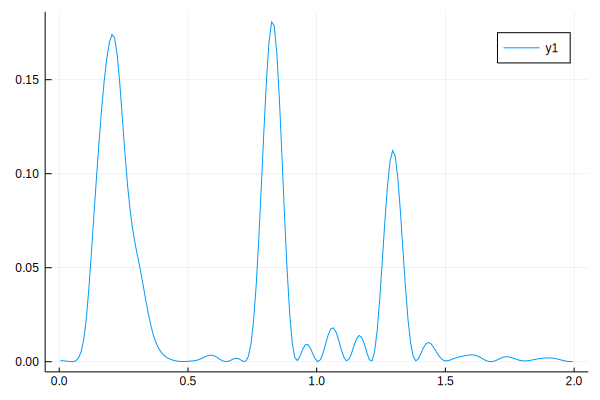

In [3]:
p = lombscargle(t, y, maximum_frequency=2, samples_per_peak=10)
plot(freqpower(p)...)

估计模型

In [4]:
m1 = LombScargle.model(t, y, findmaxfreq(p, [0, 0.5])[1]) # first model
m2 = LombScargle.model(t, y, findmaxfreq(p, [0.5, 1])[1]) # second model
m3 = LombScargle.model(t, y, findmaxfreq(p, [1, 1.5])[1]) # third model

1000-element Array{Float64,1}:
  0.036810163465155844
  0.08496416800766109 
  0.1327442808054839  
  0.1798337090122824  
  0.22592023917520518 
  0.2706983072799915  
  0.31387102470880535 
  0.3551521466782476  
  0.3942679701063643  
  0.4309591483253642  
  0.4649824106080975  
  0.49611217510744726 
  0.5241420445144868  
  ⋮                   
 -0.5226201851526636  
 -0.5031611579109823  
 -0.48017661981542004 
 -0.45381896350003764 
 -0.424262946127982   
 -0.3917045307123435  
 -0.35635958683751473 
 -0.3184624593955071  
 -0.27826441482683867 
 -0.23603197516779464 
 -0.1920451509496164  
 -0.1465955846660037  

Wiener滤波

In [5]:
signal = m1 + m2 + m3 # signal for `wiener`
noise = rand(length(y)) # noise for `wiener`
polished = wiener(y, signal, noise)

1000-element Array{Float64,1}:
 -0.6418144082499629   
 -0.4291009815061471   
 -0.343601190259027    
 -0.2792590747327702   
 -0.23384089942116823  
 -0.20896301410322227  
 -0.17189821088857918  
 -0.1785342483316518   
 -0.17611544519136335  
 -0.09743901563321143  
  0.0065022578572706425
  0.06968884105523716  
  0.09633933690641891  
  ⋮                    
 -1.5048668796667386   
 -1.5621372316792335   
 -1.520866279695712    
 -1.5127808622425827   
 -1.4049575961370817   
 -1.289769390146696    
 -1.1721069574166703   
 -1.1117106392176026   
 -1.0337003524760764   
 -0.9429930652776084   
 -0.8415178464903003   
 -0.7610958476075471   

比较结果

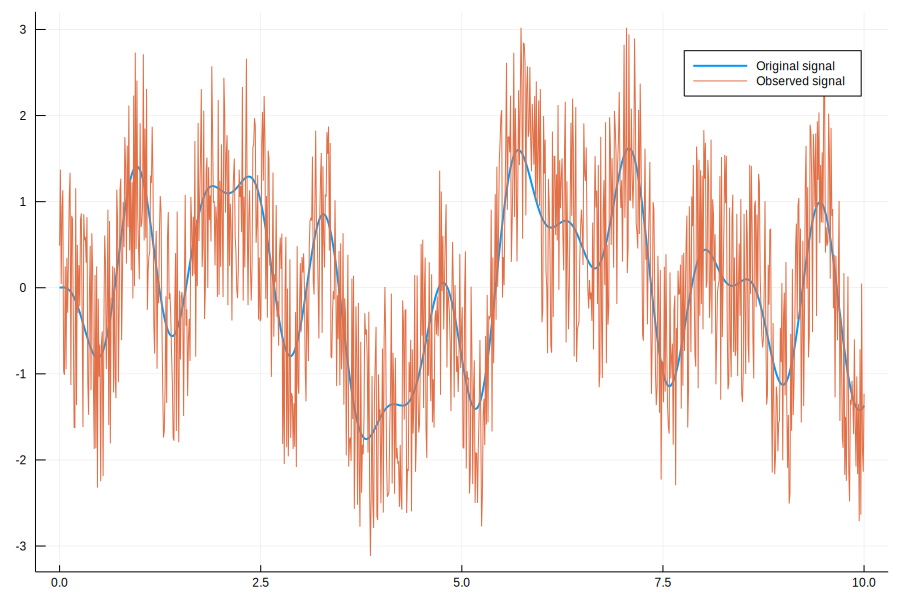

In [6]:
plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, y, label="Observed signal") # ...original and observed signal

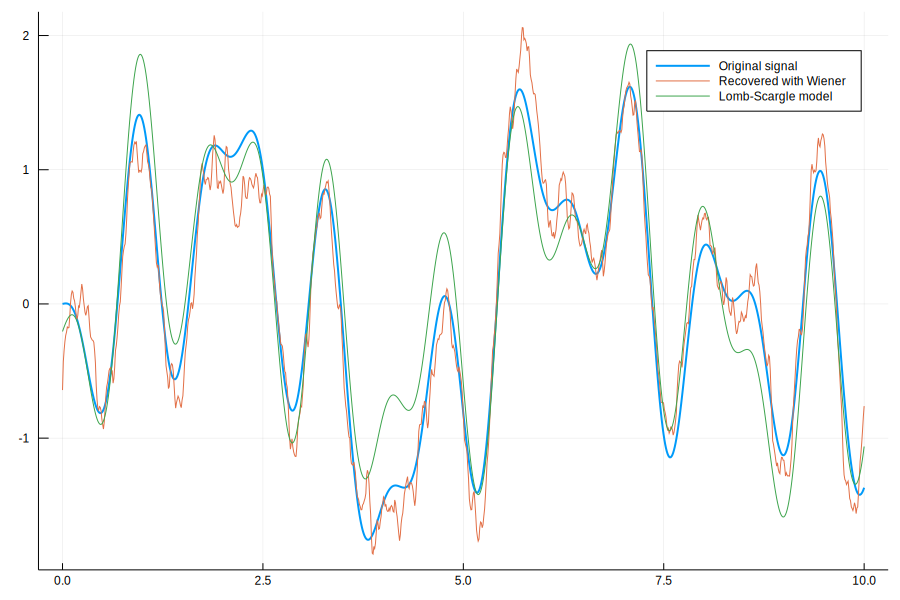

In [7]:
plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, polished, label="Recovered with Wiener") # ...original and recovered signal
plot!(t, signal, label="Lomb-Scargle model") #...and best fitting Lomb–Scargle model